# Trabajo Práctico 2: Análisis con Regresion logistica - Organización de Datos

**Alumnos y Padrón**  
* Grassano, Bruno - 103855  
* Romero, Adrián   - 103371

https://github.com/brunograssano/TP-Organizacion-de-datos

## Configuraciones iniciales

Importamos las bibiliotecas que utilizaremos a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
from preprocessing import prepararSetDeDatos
from preprocessing import prepararSetDeValidacion
from preprocessing import rlPreprocessing

In [5]:
from funcionesAuxiliares import mostrarAUCScore
from funcionesAuxiliares import mostrarROCCurve
from funcionesAuxiliares import mostrarMatrizDeConfusion
from funcionesAuxiliares import escribirPrediccionesAArchivo

## Importamos los datos y los procesamos

Leemos los datos que tenemos y llamamos a las funciones que se encargaran de dejar listos los datasets con la investigacion del TP1.

In [6]:
X = pd.read_csv('Datasets/tp-2020-2c-train-cols2.csv')
y = pd.read_csv('Datasets/tp-2020-2c-train-cols1.csv')

X = prepararSetDeDatos(X)
y = prepararSetDeValidacion(y)

## Funciones Auxiliares

Creamos una funcion que obtiene mediante grid search y K-Fold cross validation el tipo de regularizacion que maximiza la metrica de AUC ROC para el modelo de regresion logistica.

In [7]:
def obtenerMejoresHiperparametros(datosPreprocesados):
    mejor_c = 0
    mejor_valor = 0
    mejor_regularizacion = None
    y_array=np.array(y)
    for regularizacion in ["l2","none", "l1", "elasticnet"]:
        for valor_c in [0.001,0.01,0.1,0.2,0.5,0.7,1.0,1.5,2,2.5,3,3.5,4,5]:
            if(regularizacion == "elasticnet"):
                l1_ratio = 0.5
            else:
                l1_ratio = None
            kf = StratifiedKFold(n_splits=5)
            metricas = []
            for fold_idx, (train_index, test_index) in enumerate(kf.split(datosPreprocesados, y_array)):
                rl = None
                if regularizacion == "none": # Para evitar los warnings que surgen al mandar None con l1_ratio y C
                    rl = LogisticRegression(penalty = regularizacion, max_iter = 5000, solver = "saga")
                else:
                    rl = LogisticRegression(penalty = regularizacion, max_iter = 5000, solver = "saga", l1_ratio = l1_ratio, C=valor_c)
                rl.fit(datosPreprocesados[train_index], y_array[train_index].ravel())
                predicciones = rl.predict_proba(datosPreprocesados[test_index])[:, 1]
                score_obtenida = roc_auc_score(y_array[test_index],predicciones)
                metricas.append(score_obtenida)

            if np.mean(metricas) >= mejor_valor:
                mejor_valor = np.mean(metricas)
                mejor_regularizacion = regularizacion
                mejor_c = valor_c
            
    return mejor_valor, mejor_regularizacion, mejor_c

## Regresion logistica

La regresion logistica es un metodo de aprendizaje supervisado sencillo el cual consiste en obtener una curva que sirva para predecir la clase de una instancia.

Para el procesamiento de los datos aplicamos el mismo tipo de procesamiento que en otros modelos (ej. KNN). Este consiste en convertir las variables categoricas a numericas mediante OneHotEncoding y normalizar los datos que correspondan para evitar que ocurra un desvio no deseado al momento de realizar los calculos.

In [8]:
X_rl = rlPreprocessing(X)

#### Buscamos los mejores hiperparametros

En la busqueda de los hiperparametros consideramos que los mas importantes eran los siguientes:
 * Penalidad
 * C
 
Penalidad: Especifica la penalizacion del modelo. Probamos con las siguientes regularizaciones 'l1','l2,'elasticnet, y sin regularizacion.

C: Es un parametro que indica que tan fuerte es la regularizacion. Similar a SVM.

In [9]:
mejor_valor, mejor_regularizacion, mejor_c = obtenerMejoresHiperparametros(X_rl)

In [10]:
print(f"El mejor valor fue de AUC fue: {round(mejor_valor,3)}")
print(f"La regularizacion encontrada que maximiza el AUC fue: {mejor_regularizacion}")
print(f"El valor de C que maximiza el AUC fue: {mejor_c}")

El mejor valor fue de AUC fue: 0.856
La regularizacion encontrada que maximiza el AUC fue: none
El valor de C que maximiza el AUC fue: 1.0


### Evaluamos las metricas

Dividimos el set de datos en sets de training y test. Luego creamos el modelo con los hiperparametros obtenidos.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_rl, y, test_size=0.25, random_state=0)

In [12]:
rl = None
if mejor_regularizacion == "none":
    rl = LogisticRegression(penalty = mejor_regularizacion,solver = "saga",max_iter = 5000)
else:
    rl = LogisticRegression(penalty = mejor_regularizacion,l1_ratio = None,  solver = "saga", C = mejor_c,max_iter = 5000)

In [13]:
rl.fit(X_train, y_train)

C:\Users\Bruno\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(max_iter=5000, penalty='none', solver='saga')

In [14]:
y_pred = rl.predict(X_test)

Vemos los resultados ahora con las diferentes metricas.

In [15]:
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.83      0.86      0.84       121
      Vuelve       0.77      0.72      0.75        80

    accuracy                           0.81       201
   macro avg       0.80      0.79      0.80       201
weighted avg       0.80      0.81      0.80       201



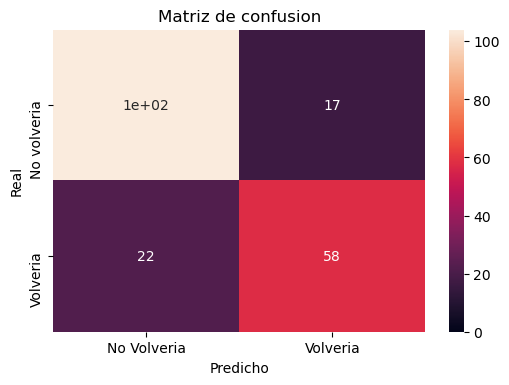

In [16]:
mostrarMatrizDeConfusion(y_pred,y_test)

Graficamos la curva ROC

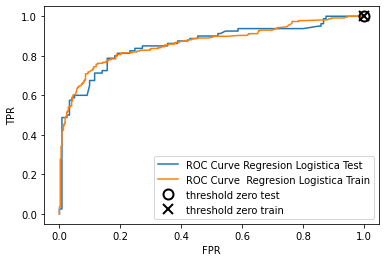

In [17]:
mostrarROCCurve(rl,"Regresion Logistica",X_test, X_train, y_test, y_train)

In [18]:
mostrarAUCScore(rl,"Regresion Logistica",X_test,y_test)

AUC para Regresion Logistica: 0.860


Observamos que se obtuvo un rendimiento bastante bueno con este modelo.

## Predicciones sobre el nuevo archivo

Obtenemos y preparamos el nuevo archivo realizando el mismo preprocesamiento realizado anteriormente.

In [19]:
holdout = pd.read_csv('Datasets/tp-2020-2c-holdout-cols2.csv')

holdout = prepararSetDeDatos(holdout)
holdout_rl = rlPreprocessing(holdout)

Realizamos las predicciones y escribimos al archivo CSV.

In [20]:
#predicciones_holdout = rl.predict(holdout_rl)

In [21]:
#predicciones_holdout

In [22]:
#escribirPrediccionesAArchivo(predicciones_holdout,"RegresionLogistica")